<a href="https://colab.research.google.com/github/anuarsantoyo/master-thesis/blob/master/220525_model_optimization_RandomWalk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 master-thesisInput:
- True Observations
- Number Training Steps

Output:
- New Model Parameter

Parts of Optimization:
- Initialization of Model Parameter
- tbd

# Initialization

## Import Libraries and Mount Drive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
from torch import distributions, optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub/master-thesis

import sys
sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/master-thesis


In [3]:
#%cd ..

In [4]:
from model.methods import *
from model.modelcore import epid_model
from model.modelhelper import *

## Optimization Settings

In [5]:
observation = 'hospitalization' #'newly_infected' #'hospitalization'
rolling_avg_obs = 2
# Overall Time Period
start_time='2020-07-31' # Mitte November/ Anfang Dezember bis Februar
end_time='2021-02-01' # Begin Vaccination Wave


train_test_split_time='2020-12-01'


dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #cuda:0

## Initialize Observations

In [6]:
df_obs_initial = pd.read_csv('data/220309_observations.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])

# Initialize Observations Training
df_obs_train, initial_newly_infected = initialize_observations(df_obs_initial, start=start_time, end=train_test_split_time, rolling_avg=rolling_avg_obs)
observed_train = torch.tensor(df_obs_train[observation], requires_grad=False, device=device, dtype=dtype)

# Initialize Observations Testing
df_obs_test, _ = initialize_observations(df_obs_initial, start=train_test_split_time, end=end_time, rolling_avg=rolling_avg_obs)
observed_test = torch.tensor(df_obs_test[observation], requires_grad=False, device=device, dtype=dtype)

# Create df_obs
observed_train_test = torch.concat((observed_train, observed_test))
df_obs = pd.concat([df_obs_train, df_obs_test])
df_obs = df_obs.reset_index(drop=True)
df_obs.head(3)

,Date,number_of_deaths,newly_infected,hospitalization
0,2020-07-31,0.5,71.0,4.0
1,2020-08-01,0.5,61.0,3.5
2,2020-08-02,0.0,71.0,3.0


In [7]:
#for column in df_obs.columns:
#  plt.plot(df_obs['Date'], df_obs[column])
#  plt.title(column)
#  plt.show()

## Initialize Model Parameter

### Initialize helper parameter

In [8]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)

### Initialize method parameter

In [9]:
method = RandomWalk(n_observations = df_obs.shape[0], device=device, dtype=dtype)

### Initialize alpha and phi

In [10]:
dict_param = initialize_parameter(['alpha', 'phi'], device, dtype)
dict_param

{'prime_values': {'alpha': tensor(-0.0020, requires_grad=True),
  'phi': tensor(-0., requires_grad=True)},
 'real_values': {'alpha': tensor(0.0280, grad_fn=<AddBackward0>),
  'phi': tensor(25., grad_fn=<AddBackward0>)}}

# Optimization

## Training

Step: 0, Learning Rate: 0.00999 Time: 0.143, Training Comparison Loss: 15290.880859375, Test Comparison Loss: 12312.724609375, Phi: 25.0 


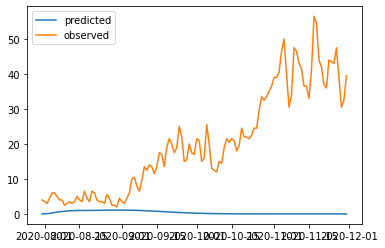

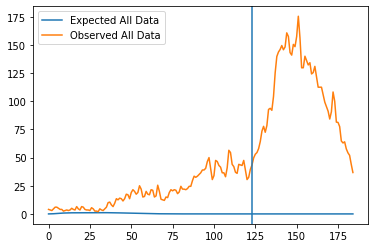

Step: 50, Learning Rate: 0.00950254422568834 Time: 0.1166, Training Comparison Loss: 13337.365234375, Test Comparison Loss: 12312.72265625, Phi: 24.88014030456543 
Step: 100, Learning Rate: 0.009038873549665948 Time: 0.1193, Training Comparison Loss: 12015.611328125, Test Comparison Loss: 12312.6494140625, Phi: 24.77200698852539 


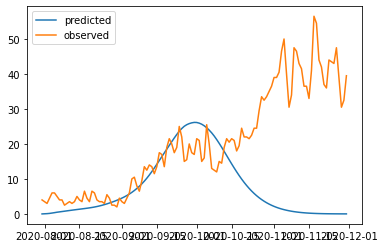

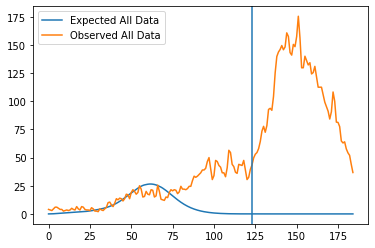

Step: 150, Learning Rate: 0.008597827393003531 Time: 0.0666, Training Comparison Loss: 9161.6083984375, Test Comparison Loss: 12309.037109375, Phi: 24.676191329956055 
Step: 200, Learning Rate: 0.008178301806491574 Time: 0.0566, Training Comparison Loss: 1866.7794189453125, Test Comparison Loss: 12133.2158203125, Phi: 24.616504669189453 


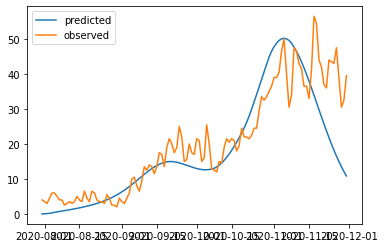

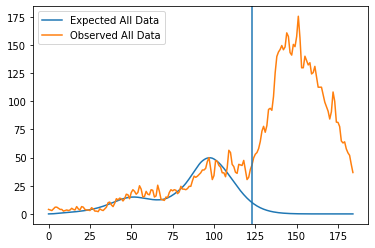

Step: 250, Learning Rate: 0.00777924670742873 Time: 0.072, Training Comparison Loss: 382.56829833984375, Test Comparison Loss: 11642.478515625, Phi: 24.604658126831055 
Step: 300, Learning Rate: 0.007399663251239432 Time: 0.058, Training Comparison Loss: 359.39984130859375, Test Comparison Loss: 11442.4111328125, Phi: 24.60076141357422 


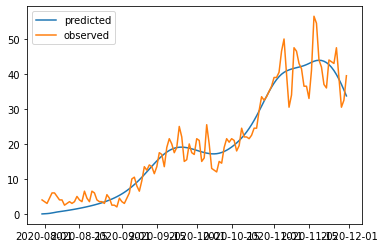

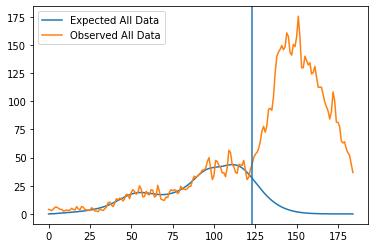

Step: 350, Learning Rate: 0.007038601331341688 Time: 0.0586, Training Comparison Loss: 361.2345886230469, Test Comparison Loss: 11303.4462890625, Phi: 24.596935272216797 
Step: 400, Learning Rate: 0.006695157201007331 Time: 0.0612, Training Comparison Loss: 364.85797119140625, Test Comparison Loss: 11183.1708984375, Phi: 24.592947006225586 


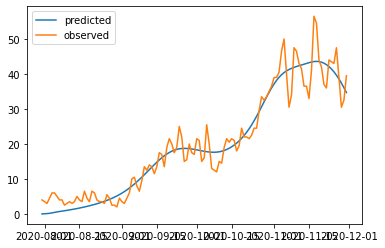

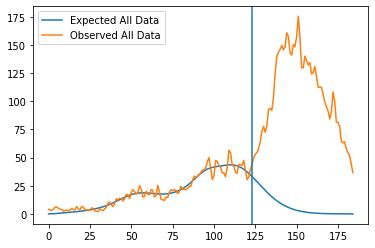

Step: 450, Learning Rate: 0.006368471211262053 Time: 0.0643, Training Comparison Loss: 369.1729736328125, Test Comparison Loss: 11063.78125, Phi: 24.58881187438965 


KeyboardInterrupt: ignored

In [11]:
from torch.optim.lr_scheduler import ExponentialLR

epochs = 1000
# model_parameter = [dict_param['prime_values']['alpha'], dict_param['prime_values']['phi']] + [dict_param['prime_values']['epsilon']]

params_to_be_optimized = method.get_parameters() + [dict_param['prime_values']['phi']]
if observation == 'hospitalization':
  params_to_be_optimized = params_to_be_optimized + [dict_param['prime_values']['alpha']]

optimizer = optim.Adam(params_to_be_optimized, lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.999)
list_R0 = []
list_sigma = []
list_phi = []
list_alpha = []

for i in range(epochs):
  iteration_time = time.time()
  optimizer.zero_grad()

  # transform alphi, phi
  dict_param = transform_prime_variables(dict_param)
  list_R0.append(method.get_R0().item())
  list_sigma.append(method.get_sigma().item())
  list_phi.append(dict_param['real_values']['phi'].item())
  list_alpha.append(dict_param['real_values']['alpha'].item())

  # forward pass
  expected = epid_model(R=method.calculate_R(), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation][:df_obs_train.shape[0]] #method.cluster_percentage_train
  
  # calc loss
  comparison_loss_train =  calc_mse(expected, observed_train) * dict_param['real_values']['phi']
  method_loss = method.calculate_loss()
  model_param_loss = calc_prior_loss(dict_param, device, dtype)
  loss = comparison_loss_train + method_loss + model_param_loss

  # backward pass
  loss.backward()
  optimizer.step()
  scheduler.step()
  
  
  with torch.no_grad():
    if i % 50==0:
        current_time = round((time.time() - iteration_time),4)
        current_lr = optimizer.state_dict()['param_groups'][0]['lr']
        expected_test = epid_model(R=method.calculate_R(), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation][-df_obs_test.shape[0]:] #method.cluster_percentage_test
        print(f"Step: {i}, Learning Rate: {current_lr} Time: {current_time}, Training Comparison Loss: {comparison_loss_train}, Test Comparison Loss: {calc_mse(expected_test, observed_test)}, Phi: {dict_param['real_values']['phi']} ")

    if i % 100==0:
      plt.plot(df_obs_train['Date'], expected.cpu().detach().numpy(), label='predicted')
      plt.plot(df_obs_train['Date'], observed_train.cpu().detach().numpy(), label='observed')
      plt.legend()
      plt.show()

      expected_train_test = epid_model(R=method.calculate_R(), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation] #cluster_percentage_train_test
      plt.plot(expected_train_test.cpu().detach().numpy(),label='Expected All Data')
      plt.plot(observed_train_test.cpu().detach().numpy(),label='Observed All Data')
      plt.axvline(x=observed_train.shape[0])
      plt.legend()
      plt.show()


# Evaluation

## Train and Test Time 

In [ ]:
expected_train_test = epid_model(R=method.calculate_R(), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation] #cluster_percentage_train_test
plt.plot(expected_train_test.cpu().detach().numpy(),label='Expected All Data')
plt.plot(observed_train_test.cpu().detach().numpy(),label='Observed All Data')
plt.axvline(x=observed_train.shape[0])
plt.legend()
plt.show()

In [ ]:
plt.plot(method.get_parameters()[0].cpu().detach().numpy())
plt.axvline(x=observed_train.shape[0])
plt.show()

In [ ]:
plt.plot(list_R0)

In [ ]:
plt.plot(list_sigma)

In [ ]:
plt.plot(list_phi)

In [ ]:
plt.plot(list_alpha)

## Eval on Test Data


In [ ]:
expected_test = expected_train_test[-df_obs_test.shape[0]:]
comparison_loss_test = calc_mse(expected_test, observed_test) * dict_param['real_values']['phi']
print(f'Comparison Loss Train: {comparison_loss_train} - Comparison Loss Test: {comparison_loss_test}')

plt.plot(df_obs_test['Date'], expected_test.cpu().detach().numpy(),label='Expected Test Data')
plt.plot(df_obs_test['Date'], observed_test.cpu().detach().numpy(),label='Observed Test Data')
plt.legend()
plt.show()

Eval Newly Infected

In [ ]:
expected_newly = epid_model(R=method.calculate_R(), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)['newly_infected']

plt.plot(expected_newly.cpu().detach().numpy(),label='Expected Newly Infected')
plt.plot(df_obs['newly_infected'],label='Observed Newly Infected')
plt.axvline(x=observed_train.shape[0])
plt.legend()
plt.show()